In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [7]:
import wandb
wandb.login()

True

# Imports 

In [8]:
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DistilBertModel

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [265]:
import sys
#sys.path.append('/lfs/1/sahaana/enrichment/enrich/utils')
sys.path.append('/lfs/1/sahaana/enrichment/ember/utils')
 
    
from embedding_datasets import SQuADDataset, EmberEvalDataset
from embedding_models import TripletSingleBERTModel
from embedding_utils import param_header, tokenize_batch  
from embedding_runner import train_model, eval_model
#from model_utils import MatchedDatasetTriplets, param_header_bert, tokenize_batch   
#from models import BatchedTripletSingleTowerModel, BatchedTripletSingleBERTModel
#from model_runner import train_model, eval_model
from knn_utils import FaissKNeighbors, knn_SQuAD_recall #, knn_matching_accuracy, find_perfect_recall

In [10]:
%load_ext autoreload
%autoreload 2

# Load Processed (cleaned, aligned) Datasets

In [11]:
left = '/lfs/1/sahaana/enrichment/data/SQuAD/train_tableA_processed.pkl'
right = '/lfs/1/sahaana/enrichment/data/SQuAD/train_tableB_sent_processed.pkl'

left = pd.read_pickle(left)
right = pd.read_pickle(right)

In [12]:
left

,question,merged_all
QID,,
0,When did Beyonce start becoming popular?,[SEP] question When did Beyonce start becomi...
1,What areas did Beyonce compete in when she was...,[SEP] question What areas did Beyonce compet...
2,When did Beyonce leave Destiny's Child and bec...,[SEP] question When did Beyonce leave Destin...
3,In what city and state did Beyonce grow up?,[SEP] question In what city and state did Be...
4,In which decade did Beyonce become famous?,[SEP] question In which decade did Beyonce b...
...,...,...
86816,In what US state did Kathmandu first establish...,[SEP] question In what US state did Kathmand...
86817,What was Yangon previously known as?,[SEP] question What was Yangon previously kn...
86818,With what Belorussian city does Kathmandu have...,[SEP] question With what Belorussian city do...


In [13]:
right

,sentence,merged_all
SID,,
2,"Born and raised in Houston, Texas, she perfor...","[SEP] sentence Born and raised in Houston, ..."
6,Their hiatus saw the release of Beyoncé's deb...,[SEP] sentence Their hiatus saw the release...
4,"Managed by her father, Mathew Knowles, the gr...","[SEP] sentence Managed by her father, Mathe..."
11,"Beyoncé also ventured into acting, with a Gol...",[SEP] sentence Beyoncé also ventured into a...
13,Her marriage to rapper Jay Z and portrayal of...,[SEP] sentence Her marriage to rapper Jay Z...
...,...,...
228258,A recent extension to the international termi...,[SEP] sentence A recent extension to the in...
228260,"Since 2013, Turkish Airlines connects Istanbu...","[SEP] sentence Since 2013, Turkish Airlines..."
228267,KMC's first international relationship was es...,[SEP] sentence KMC's first international re...


(array([8.6767e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

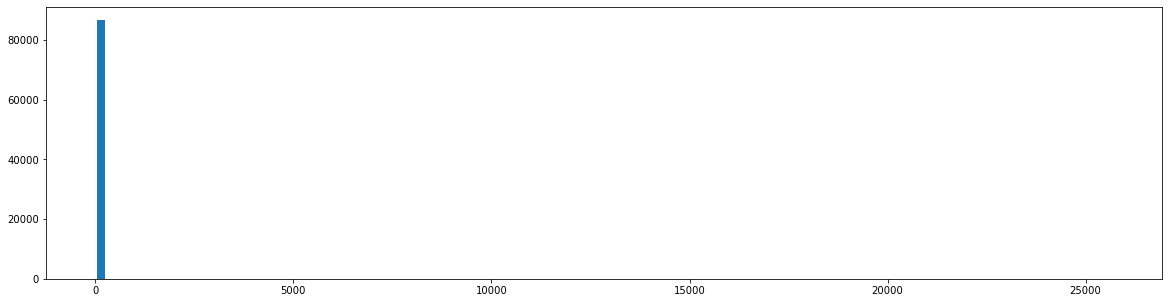

In [18]:
plt.figure(figsize=(20,5))
plt.hist(left['merged_all'].apply(lambda x: len(x)), bins=100, rwidth = .85)

(array([1.420e+02, 4.020e+02, 7.110e+02, 1.417e+03, 1.070e+03, 2.702e+03,
        3.513e+03, 4.164e+03, 4.371e+03, 2.429e+03, 4.705e+03, 4.519e+03,
        4.411e+03, 3.881e+03, 1.839e+03, 3.243e+03, 2.798e+03, 2.444e+03,
        2.100e+03, 8.770e+02, 1.577e+03, 1.245e+03, 1.110e+03, 4.680e+02,
        7.740e+02, 5.990e+02, 5.000e+02, 3.860e+02, 1.650e+02, 3.110e+02,
        2.420e+02, 1.870e+02, 1.530e+02, 7.400e+01, 9.700e+01, 9.500e+01,
        8.200e+01, 4.600e+01, 2.000e+01, 4.700e+01, 3.700e+01, 3.900e+01,
        1.200e+01, 2.200e+01, 1.900e+01, 1.800e+01, 1.900e+01, 3.000e+00,
        1.400e+01, 1.000e+01, 8.000e+00, 4.000e+00, 5.000e+00, 4.000e+00,
        6.000e+00, 7.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+0

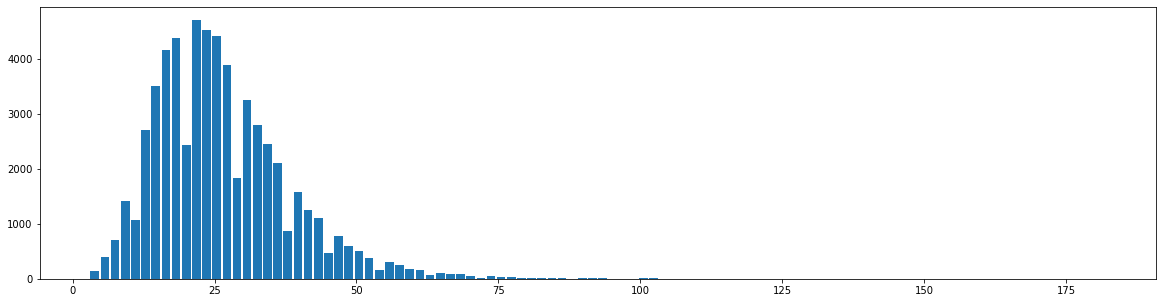

In [16]:
plt.figure(figsize=(20,5))
plt.hist(right['merged_all'].apply(lambda x: len(x)), bins=100, rwidth = .85)

# Prepping Data Indices

In [112]:
train_df = '/lfs/1/sahaana/enrichment/data/SQuAD/train_sent_triplets.pkl'
train_df = pd.read_pickle(train_df)

val_df = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_sent_labels.pkl'
val_df = pd.read_pickle(val_df)

## Model H Params

In [113]:
epochs = 1
batch_size = 8
final_size = 200
lr = .00001
tl_margin = 1.0
tl_p = 2
pool_type = "CLS"
column = "merged_all"
shuffle = True
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer_max_length = 512
compute_val = False
train_size = len(train_df)
    

bert_path='/lfs/1/sahaana/enrichment/ember/pretraining/models/SQuAD_sent-uncased-masked-ALL-BM25'
bert_model = DistilBertModel.from_pretrained(bert_path, return_dict=True)

model_name = f'SQuAD_sent-uncased-masked-ALL-BM25'

## DataLoaders

In [119]:
train_data = DataLoader(SQuADDataset(left, right, len(train_df), column, train_df), 
                        batch_size=batch_size,
                        shuffle = shuffle
                        )

val_data = None 
"""DataLoader(SQuADDataset(left, right, len(val_df), column, val_df), 
                       batch_size=batch_size,
                       shuffle = False
                      )"""

'DataLoader(SQuADDataset(left, right, len(val_df), column, val_df), \n                       batch_size=batch_size,\n                       shuffle = False\n                      )'

## Init and Run Model

In [120]:
triplet_loss = nn.TripletMarginLoss(margin=tl_margin, p=tl_p)
losses = []
val_losses = []
model = TripletSingleBERTModel(final_size, pool_type, bert_path)
optimizer = optim.AdamW(model.parameters(), lr=lr)#optim.SGD(model.parameters(), lr=lr)

In [121]:
save_dir = param_header(batch_size, final_size, lr, pool_type, epochs, train_size)
save_dir = f'models/{model_name}/{save_dir}/'

In [122]:
wandb.init(project=model_name)

Epoch,0
_step,836
_runtime,102
_timestamp,1613433868
train batch loss,0.38054


Epoch,▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train batch loss,▃█▃▄▃▃▃▃▅▃▃▃▄▃▄▄▅▂▃▂▃▅▂▇▃▅▂▄▁▁▂▃▄▂▂▆▃▅▃▂


wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [123]:
train_model(model, 
            tokenizer, 
            tokenize_batch, 
            train_data, 
            val_data, 
            triplet_loss, 
            optimizer, 
            epochs, 
            losses, 
            val_losses, 
            save_dir, 
            compute_val, 
            tokenizer_max_length = tokenizer_max_length)

# k-NN Model Performance

In [296]:
left_eval = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_tableA_processed.pkl'
right_eval = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_tableB_sent_processed.pkl'
test = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_sent_labels.pkl'

left_eval = pd.read_pickle(left_eval)
right_eval = pd.read_pickle(right_eval)
test_df = pd.read_pickle(test)

In [297]:
#PATH = "models/single-tower-BERT-triplet-model/batch_size-8-final_size-50-opt_lr-0.0001-tloss_margin-1.0-tloss_p-2-pooling-CLS-shuffle-True00-35-05-01-21"
#model.load_state_dict(torch.load(PATH))

left_eval_data = DataLoader(EmberEvalDataset(left_eval, column, indexed=True), 
                       batch_size=batch_size,
                       shuffle = False
                      )
right_eval_data = DataLoader(EmberEvalDataset(right_eval, column, indexed=True), 
                       batch_size=batch_size,
                       shuffle = False
                      )

In [298]:
left_index, left_embeddings = eval_model(model, tokenizer, left_eval_data, tokenizer_max_length=512)
right_index, right_embeddings = eval_model(model, tokenizer, right_eval_data, tokenizer_max_length=512)

In [299]:
knn = FaissKNeighbors(k=30)
knn.fit(right_embeddings)
neib = knn.kneighbors(left_embeddings)

In [300]:
for k in range(1,31):
    avg, count, MRR, results, MRR_results = knn_SQuAD_recall(neib[0], neib[1], test_df, left_index, right_index, 'SID', k=k)
    print(f"k: {k} \t avg: {avg} \t count: {count} \t MRR: {MRR}")

k: 1 	 avg: 0.5761052986837665 	 count: 3414 	 MRR: 0.5761052986837665
k: 2 	 avg: 0.6734728315896051 	 count: 3991 	 MRR: 0.6247890651366858
k: 3 	 avg: 0.7247721903476206 	 count: 4295 	 MRR: 0.6418888513893576
k: 4 	 avg: 0.7537968275396557 	 count: 4467 	 MRR: 0.6491450106873664
k: 5 	 avg: 0.7765777927775903 	 count: 4602 	 MRR: 0.6537012037349532
k: 6 	 avg: 0.792102598717516 	 count: 4694 	 MRR: 0.6562886713916076
k: 7 	 avg: 0.8045899426257171 	 count: 4768 	 MRR: 0.6580725776642078
k: 8 	 avg: 0.8164022949713129 	 count: 4838 	 MRR: 0.6595491217074072
k: 9 	 avg: 0.8246709416132298 	 count: 4887 	 MRR: 0.6604678602231758
k: 10 	 avg: 0.8324333445831927 	 count: 4933 	 MRR: 0.661244100520172
k: 11 	 avg: 0.8383395207559905 	 count: 4968 	 MRR: 0.66178102562679
k: 12 	 avg: 0.8449206884913939 	 count: 5007 	 MRR: 0.662329456271407
k: 13 	 avg: 0.8503206209922376 	 count: 5039 	 MRR: 0.6627448356945488
k: 14 	 avg: 0.8558893013837326 	 count: 5072 	 MRR: 0.6631425985796556
k: 15 